# Handling with Missing Values

In this notebook we will discuss some techniques that can be used to deal with missing values in tabular data.

This notebook was presented live on Abhishek Thakur's youtube channel. 
- Watch here: https://www.youtube.com/watch?v=EYySNJU8qR0
- My twitch channel: [www.twitch.tv/medallionstallion_](https://www.twitch.tv/medallionstallion_)
- My youtube channel: https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw

<div> <img src="https://i.imgur.com/SkG4HMS.jpg" alt="Drawing" style="height: 350px;"/></div> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("../input/song-popularity-prediction/train.csv")
test = pd.read_csv("../input/song-popularity-prediction/test.csv")
ss = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")

train["isTrain"] = True
test["isTrain"] = False

tt = pd.concat([train, test]).reset_index(drop=True).copy()

In [3]:
FEATURES = [
    "song_duration_ms",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "audio_mode",
    "speechiness",
    "tempo",
    "time_signature",
    "audio_valence",
]

In [4]:
train.shape, test.shape, tt.shape

((40000, 16), (10000, 15), (50000, 16))

# Before we start.... why are the missing values there?

Example causes of missing data:
- Sensor data where the sensor went offline.
- Survey data where some questions were not answered.
- A Kaggle competition where the host wants to make the problem hard :D

You need to understand *Why* you have missing values before deciding on the approach for dealing with them.

# Quick Missing Values EDA
## What are the counts of missing values in train vs. test?

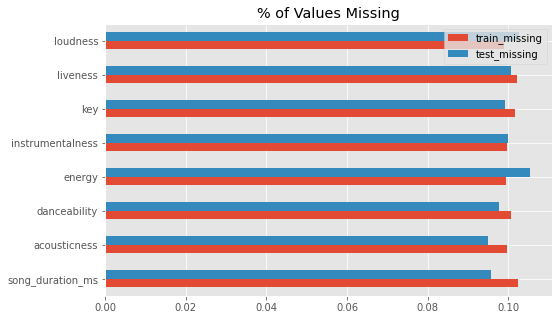

In [5]:
ncounts = pd.DataFrame([train.isna().mean(), test.isna().mean()]).T
ncounts = ncounts.rename(columns={0: "train_missing", 1: "test_missing"})

ncounts.query("train_missing > 0").plot(
    kind="barh", figsize=(8, 5), title="% of Values Missing"
)
plt.show()

In [6]:
nacols = [
    "song_duration_ms",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
]

## How many missing values per observation?

In [7]:
tt["n_missing"] = tt[nacols].isna().sum(axis=1)
train["n_missing"] = train[nacols].isna().sum(axis=1)
test["n_missing"] = test[nacols].isna().sum(axis=1)

<AxesSubplot:title={'center':'Number of Missing Values per Sample'}>

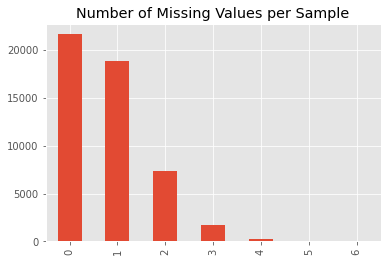

In [8]:
tt["n_missing"].value_counts().plot(
    kind="bar", title="Number of Missing Values per Sample"
)

In [9]:
tt.query("n_missing == 6")

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity,isTrain,n_missing
13457,13457,176401.0,NaN,NaN,0.833408,NaN,NaN,NaN,NaN,0,0.052580,142.802779,3,0.546615,0.0,True,6
19697,19697,NaN,NaN,NaN,NaN,0.003014,NaN,NaN,-10.708472,0,0.035591,95.181833,3,0.483101,0.0,True,6
48594,8594,NaN,NaN,NaN,0.344299,NaN,2.0,NaN,NaN,1,0.035495,151.125383,4,0.463903,NaN,False,6


## Do we see an imbalance in missing values when splitting by other features?

In [10]:
cat_features = ["key", "audio_mode"]
tt.groupby("audio_mode")["n_missing"].mean()

audio_mode
0    0.804547
1    0.799677
Name: n_missing, dtype: float64

In [11]:
tt.groupby("time_signature")["n_missing"].agg(['mean','count'])

,mean,count
time_signature,,
2,0.786337,688
3,0.805649,29174
4,0.800352,19895
5,0.744856,243


In [12]:
train.groupby("song_popularity")["n_missing"].mean()

song_popularity
0    0.807505
1    0.799739
Name: n_missing, dtype: float64

# Prep - Create Tag Columns with Missing Indicators

In [13]:
tt_missing_tag_df = tt[nacols].isna()
tt_missing_tag_df.columns = \
    [f"{c}_missing" for c in tt_missing_tag_df.columns]

In [14]:
tt = pd.concat([tt, tt_missing_tag_df], axis=1)

# Protip:
- Try to predict the target using only missing value indicators as features

In [15]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

lr = LogisticRegressionCV(scoring="accuracy")

X = tt.query("isTrain")[
    [
        "song_duration_ms_missing",
        "acousticness_missing",
        "danceability_missing",
        "energy_missing",
        "instrumentalness_missing",
        "key_missing",
        "liveness_missing",
        "loudness_missing",
    ]
]

y = tt.query("isTrain")["song_popularity"]

lr.fit(X, y)
lr.score(X, y)

preds = lr.predict_proba(X)[:, 0]

roc_auc_score(y, preds)

0.4928022710677621

# Level 0: Do Nothing!
https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
- Tree Type Models like LightGBM and XGBoost can work with NA values

- Other types of regression or neural networks will require some sort of imputation.

In [16]:
# use_missing (default)
# or zero_as_missing are params that can be used 
import lightgbm as lgb
lgbm_params = {
    'objective': 'regression',
    'metric': 'auc',
    'verbose': -1,
    'boost_from_average': False,
    'min_data': 1,
    'num_leaves': 2,
    'learning_rate': 1,
    'min_data_in_bin': 1,
#     'use_missing': False,
#     'zero_as_missing': True
}

model = lgb.LGBMClassifier(params=lgbm_params)

# Level 1: Drop 'em

![img](https://i.imgur.com/hmqbGOo.jpg)

- Drop all rows with missing values (axis=0)
    - This doesn't work on test because we can't just not predict those values
- Drop all missing columns:
    - This leaves us with much less features to use

In [17]:
tt.shape, tt.dropna(axis=0).shape

((50000, 25), (17259, 25))

In [18]:
tt.shape, tt.dropna(axis=1).shape

((50000, 25), (50000, 16))

In [19]:
# Dropna based only on a subset of columns
_ = train.dropna(subset=['song_duration_ms'])

# Level 2: Pandas Imputation
![img](https://i.imgur.com/Qas2RHT.jpg)
- Fill missing values using `fillna`
- `ffill` and `bfill`
- `groupby` fills

In [20]:
# Fill with a default value
tt['song_duration_ms'].fillna(-999).head(5)

0    212990.0
1      -999.0
2    193213.0
3    249893.0
4    165969.0
Name: song_duration_ms, dtype: float64

In [21]:
# Impute with mean
tt["song_duration_ms_mean_imp"] = tt["song_duration_ms"].fillna(
    tt["song_duration_ms"].mean()
)

tt.loc[tt['song_duration_ms'].isna()] \
    [["song_duration_ms", "song_duration_ms_mean_imp"]] \
    .head(5)

,song_duration_ms,song_duration_ms_mean_imp
1,NaN,193150.809021
13,NaN,193150.809021
14,NaN,193150.809021
15,NaN,193150.809021
28,NaN,193150.809021


In [22]:
# Impute with median

tt["song_duration_ms_median_imp"] = tt["song_duration_ms"].fillna(
    tt["song_duration_ms"].median()
)

tt.loc[tt['song_duration_ms'].isna()] \
    [["song_duration_ms",
      "song_duration_ms_mean_imp",
     "song_duration_ms_median_imp"]] \
    .head(5)

,song_duration_ms,song_duration_ms_mean_imp,song_duration_ms_median_imp
1,NaN,193150.809021,186552.5
13,NaN,193150.809021,186552.5
14,NaN,193150.809021,186552.5
15,NaN,193150.809021,186552.5
28,NaN,193150.809021,186552.5


## Protip: filling for time series data.
- `ffill()` and `bfill()`

In [23]:
ts_data = pd.DataFrame(index=[x / 5 for x in range(100)])
ts_data["data"] = np.sin(ts_data.index)
ts_data["data_missing"] = ts_data["data"] \
    .sample(frac=0.9, random_state=529)
ts_data["data_ffill"] = ts_data["data_missing"].ffill()
ts_data["data_mean_fill"] = ts_data["data_missing"].fillna(
    ts_data["data_missing"].mean()
)

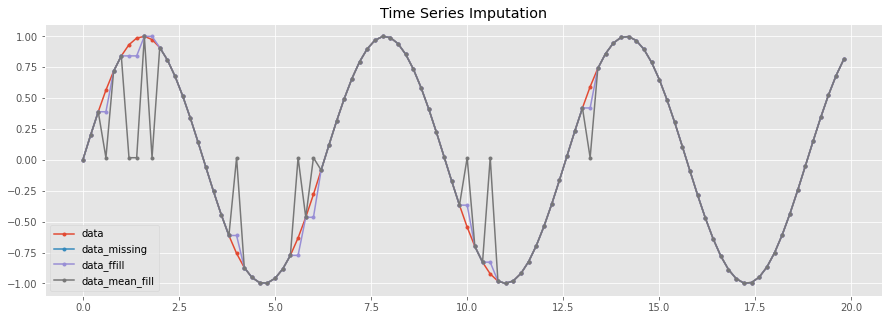

In [24]:
ts_data.plot(style=".-",
             figsize=(15, 5),
             title='Time Series Imputation')
plt.show()

## GroupBy Fill
- Use the average value grouped by a different feature
- As an example we will use the `audio_mode` feature

In [25]:
sd_mean_map = tt.groupby("audio_mode")["song_duration_ms"] \
    .mean().to_dict()
sd_mean_map

{0: 193860.63699819762, 1: 191649.42961114578}

In [26]:
sd_mean_series = tt['audio_mode'].map(sd_mean_map)

In [27]:
tt["song_duration_ms_mean_audio_mode"] = \
    tt["song_duration_ms"].fillna(sd_mean_series)

In [28]:
tt.query('song_duration_ms_missing == True') \
    [['id','audio_mode','song_duration_ms_mean_audio_mode']].head(5)

,id,audio_mode,song_duration_ms_mean_audio_mode
1,1,1,191649.429611
13,13,0,193860.636998
14,14,0,193860.636998
15,15,0,193860.636998
28,28,0,193860.636998


# Level 3: Sklearn Imputation
![img](https://i.imgur.com/eVKTU5p.jpg)

- `SimpleImputer` Similar to pandas `fillna`
- `IterativeImputer`
- `KNNImputer`

Using SKlearn is good because it provides a `fit` and `transform` method. This allows us to fit on the training and transform on both the train validation.

In real world situations you will want to `fit` and `transform` *within* your cross validation loop to ensure no leakage.

**Protip: in kaggle competitions we sometimes know all of the features for the test set. So it may be advantageous to fit on all the data.** This doesn't work for "code" competitions because we can't see the test data before out model predicts.

## SimpleImputer
- Impute with the mean value, median, and just a single value
- `add_indicator` will add the indicator column

In [29]:
from sklearn.impute import SimpleImputer
imptr = SimpleImputer(strategy="mean", add_indicator=False)

In [30]:
train['song_duration_ms'].mean()

193165.84757235576

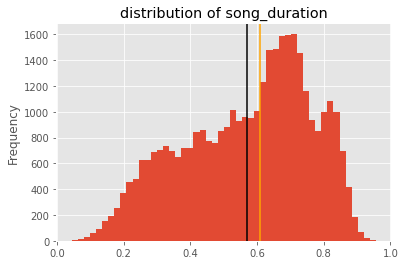

In [31]:
ax = train['danceability'] \
    .plot(kind='hist', bins=50,
          title='distribution of song_duration')
ax.axvline(train['danceability'].mean(),
           color='black')
ax.axvline(train['danceability'].median(),
           color='orange')

In [32]:
# Fit / Transform on train, transform only on val/test
tr_imp = imptr.fit_transform(train[FEATURES])
test_imp = imptr.transform(test[FEATURES])

In [33]:
# For kaggle competition you can kind of cheat by fitting on all data
tt_impute = imptr.fit_transform(tt[FEATURES])
tt_simple_impute = pd.DataFrame(tt_impute, columns=FEATURES)
tt_simple_impute.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198086,-5.619088,0.0,0.082570,158.386236,4.0,0.734642
1,193150.809021,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1.0,0.127358,102.752988,3.0,0.711531
2,193213.000000,0.277183,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0.0,0.052282,178.685791,3.0,0.425536
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0.0,0.035618,128.715630,3.0,0.453597
4,165969.000000,0.493017,0.570724,0.740982,0.002033,10.0,0.094891,-2.684095,0.0,0.050746,121.928157,4.0,0.741311


# Iterative Imputer!

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

Multivariate imputer that estimates each feature from all the others.

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

Uses by default the `BayesianRidge` model to impute

- *Protip* : We want to `fit` and `predict` on all columns! This is because the model is using all features to help fill the missing values.

In [34]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [35]:
%%time
it_imputer = IterativeImputer(max_iter=10)
train_iterimp = it_imputer.fit_transform(train[FEATURES])
test_iterimp = it_imputer.transform(test[FEATURES])
tt_iterimp = it_imputer.fit_transform(tt[FEATURES])

# Create train test imputed dataframe
tt_iter_imp_df = pd.DataFrame(tt_iterimp, columns=FEATURES)

CPU times: user 5.04 s, sys: 10 s, total: 15.1 s
Wall time: 3.8 s


In [36]:
# Save this off to use later
tt_iter_imp_df.to_parquet("tt_iterative_imp.parquet")

## KNN Imputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

Imputation for completing missing values using k-Nearest Neighbors.

In [37]:
%%time
from sklearn.impute import KNNImputer

knn_imptr = KNNImputer(n_neighbors=1)
train_knnimp = knn_imptr.fit_transform(train[FEATURES])
test_knnimp = knn_imptr.transform(test[FEATURES])
tt_knnimp = knn_imptr.fit_transform(tt[FEATURES])
tt_imp = pd.DataFrame(tt_knnimp, columns=FEATURES)

# Create KNN Train/Test imputed dataframe
knn_imp_df = pd.DataFrame(tt_imp, columns=FEATURES)

CPU times: user 2min 3s, sys: 39.6 s, total: 2min 42s
Wall time: 2min


In [38]:
# Save this off to use later
knn_imp_df.to_parquet("tt_knn_imp.parquet")

# Level 4: LightGBM Imputer!!

![img](https://i.imgur.com/i0vWAcc.jpg)

<!-- ![img](https://avatars.githubusercontent.com/u/9374781?v=4) -->

Shoutout to analokmaus:
<div> <img src="https://avatars.githubusercontent.com/u/9374781?v=4" alt="Drawing" style="height: 100px;"/></div>

https://github.com/analokmaus/kuma_utils/blob/master/preprocessing/imputer.py

In [39]:
# !rm -r kuma_utils
!git clone https://github.com/analokmaus/kuma_utils.git

Cloning into 'kuma_utils'...
remote: Enumerating objects: 881, done.
remote: Counting objects: 100% (597/597), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 881 (delta 371), reused 382 (delta 166), pack-reused 284
Receiving objects: 100% (881/881), 692.46 KiB | 2.00 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [40]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [41]:
%%time
lgbm_imtr = LGBMImputer(n_iter=100, verbose=True)

train_lgbmimp = lgbm_imtr.fit_transform(train[FEATURES])
test_lgbmimp = lgbm_imtr.transform(test[FEATURES])
tt_lgbmimp = lgbm_imtr.fit_transform(tt[FEATURES])
tt_imp = pd.DataFrame(tt_lgbmimp, columns=FEATURES)

# Create LGBM Train/Test imputed dataframe
lgbm_imp_df = pd.DataFrame(tt_imp, columns=FEATURES)

song_duration_ms:	regression...iter100/100
acousticness:	regression...iter100/100
danceability:	regression...iter1/100
energy:	regression...iter100/100
instrumentalness:	regression...iter100/100
key:	regression...iter100/100
liveness:	regression...iter100/100
loudness:	regression...iter100/100
song_duration_ms:	regression...iter100/100
acousticness:	regression...iter100/100
danceability:	regression...iter1/100
energy:	regression...iter100/100
instrumentalness:	regression...iter100/100
key:	regression...iter100/100
liveness:	regression...iter100/100
loudness:	regression...iter100/100
CPU times: user 20.6 s, sys: 21.3 ms, total: 20.6 s
Wall time: 5.32 s


In [42]:
tt_lgbm_imp = pd.concat([tt[["id", "isTrain",
                             "song_popularity"]],
                         tt_lgbmimp], axis=1)

In [43]:
tt_lgbm_imp.to_parquet("tt_lgbm_imp.parquet")

# Check The Imputation Distribution

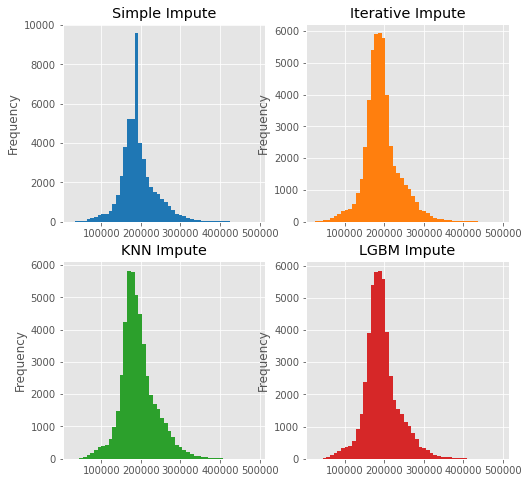

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

tt_simple_impute['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[0],
          title='Simple Impute',
         color=color_pal[0])

tt_iter_imp_df['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[1],
          title='Iterative Impute',
         color=color_pal[1])

knn_imp_df['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[2],
          title='KNN Impute',
         color=color_pal[2])

tt_lgbm_imp['song_duration_ms'] \
    .plot(kind='hist',
          bins=50,
          ax=axs[3],
          title='LGBM Impute',
         color=color_pal[3])
plt.show()

# Which Method is Best?
- Try and check on cross validation!

# THE END!

I hope you've learned something new about how to deal with missing values!